MLP for BCH(15, 7, 2)

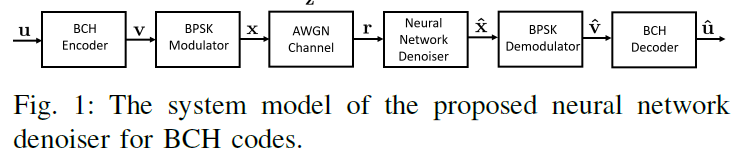

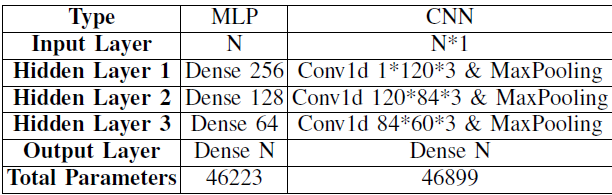

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, ConcatDataset, Dataset
from torchvision import datasets, transforms
import torch.nn.functional as F
import numpy as np
import random
import csv
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import time

In [2]:
#BCH(15, 7, 2)
n = 15
k = 7
t = 2

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Eb_N0_test = [0, 1, 2, 3, 4, 5, 6, 7]

# hyperparameters
input_size = n
output_size = n
batch_size = 8
hidden_size_1 = 256
hidden_size_2 = 128
hidden_size_3 = 64
learning_rate = 0.0005

Read and prepare datasets

In [4]:
class CustomDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        labels = torch.tensor([float(x) for x in self.data.iloc[idx, 1].split(',')]).float()
        features = torch.tensor([float(x) for x in self.data.iloc[idx, 3].split(',')]).float()

        if self.transform:
            features = self.transform(features)
        return labels, features

In [5]:
test_dataset, test_loader = {}, {}

train_dataset = CustomDataset(csv_file="train_dataset.csv", transform=None)
for elem in Eb_N0_test:
    test_dataset[elem] = CustomDataset(csv_file=f"test_dataset/test_dataset_{elem}.csv", transform=None)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)  
for elem in Eb_N0_test:
    test_loader[elem] = DataLoader(dataset=test_dataset[elem], batch_size=batch_size, shuffle=False)

print(len(train_dataset), len(train_loader), len(test_dataset[0]), len(test_loader[0]))
print(train_dataset[34567])
print(test_dataset[3][1483])

100096 12512 125056 15632
(tensor([0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1.]), tensor([ 0.8317, -1.2640,  0.5736, -1.3900, -0.1949,  0.4351,  1.0525, -1.2029,
         0.1784,  1.4942,  1.0352, -0.7556, -0.6715, -0.5234, -1.5511]))
(tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 0., 0., 1.]), tensor([ 0.6452,  0.1995,  0.9710,  1.0041,  0.8379,  1.2816, -1.1709, -0.7907,
        -1.0328,  0.4010, -1.1391,  0.7684,  0.8681,  0.3751, -0.7922]))


Multi Layer Perceptron network

In [6]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size_1),
            nn.ReLU(),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.ReLU(),
            nn.Linear(hidden_size_2, hidden_size_3),
            nn.ReLU(),
            nn.Linear(hidden_size_3, output_size),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
model = MLP(input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size).to(device)
# print(model)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Count BER function

In [8]:
def count_ber(input_codeword, output_codeword):
    ber = torch.mean((input_codeword != output_codeword).float()).item()
    return ber

Test function

In [9]:
# test_samples = 1_000_448

def test(Eb_N0):  # Domyślnie testujemy wszystkie próbki w test_loader
    model.eval()
    
    total_correct = 0
    total_samples = 0
    running_ber = 0.0
    running_loss = 0.0
    num_of_test_batches = len(Eb_N0) * len(test_loader[0])
    
    for elem in Eb_N0:
        predictions[elem] = []
        
        with torch.no_grad():  # Nie obliczaj gradientów
            for i, (batch_labels, batch_features) in enumerate(test_loader[elem]):
                    
                batch_labels = batch_labels.to(device)
                batch_features = batch_features.to(device)
                    
                # Forward pass
                outputs = model(batch_features)
                loss = criterion(outputs, batch_labels)
                running_loss += loss.item()
                    
                # Użyj Sigmoidu do przekształcenia wyjść w przedziale [0, 1]
                predicted = (outputs > 0.5).float()
                    
                # Zliczaj poprawne przewidywania i liczbę etykiet
                total_correct += torch.sum(torch.all(predicted == batch_labels, dim=1)).item()
                
                total_samples += batch_size
                    
                # Sumuj BER dla każdego batcha
                running_ber += count_ber(predicted, batch_labels)

                batch_predictions = [", ".join(map(str, pred.tolist())) for pred in predicted]
                predictions[elem].extend(batch_predictions)
    
    
    # Oblicz średnie metryki na podstawie wszystkich próbek
    average_test_loss = running_loss / num_of_test_batches
    average_ber = running_ber / num_of_test_batches
    accuracy = 100.0 * total_correct / total_samples
    
    print(f'Testing  - Loss: {average_test_loss:.4f}, BER: {average_ber:.4f}, Accuracy: {accuracy:.2f}%  ({total_samples}) ({num_of_test_batches})')

    return average_test_loss

Training

In [10]:
num_epochs = 12
train_losses = []
test_losses = []
predictions = {}

# start training time measurement
start_time = time.time()

for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    running_loss = 0.0
    running_ber = 0.0

    for batch_labels, batch_features in train_loader:

        batch_labels = batch_labels.to(device)
        batch_features = batch_features.to(device)
        
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        running_loss += loss.item()
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        predicted = (outputs > 0.5).float()
        running_ber += count_ber(predicted, batch_labels)

        total_correct += torch.sum(torch.all(predicted == batch_labels, dim=1)).item()
        total_samples += batch_size
    
    average_train_loss = running_loss / len(train_loader)
    train_losses.append(average_train_loss)
    
    average_ber = running_ber / len(train_loader)
    accuracy = 100.0 * total_correct / total_samples

    
    print(f'Epoch [{epoch + 1}/{num_epochs}]')
    print(f'Training - Loss: {average_train_loss:.4f}, BER: {average_ber:.4f}, Accuracy: {accuracy:.2f}%  ({total_samples})')

    
    # Testowanie modelu
    test_loss = test([0])
    test_losses.append(test_loss)


# finish training time measurement
end_time = time.time()

# Calculate elapsed time
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)

# Display total training time
print(f'\nTotal training time: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}')

Epoch [1/12]
Training - Loss: 0.1571, BER: 0.0616, Accuracy: 46.26%  (100096)
Testing  - Loss: 0.1047, BER: 0.0388, Accuracy: 63.59%  (125056) (15632)
Epoch [2/12]
Training - Loss: 0.0845, BER: 0.0307, Accuracy: 71.98%  (100096)
Testing  - Loss: 0.0688, BER: 0.0247, Accuracy: 78.09%  (125056) (15632)
Epoch [3/12]
Training - Loss: 0.0616, BER: 0.0220, Accuracy: 81.06%  (100096)
Testing  - Loss: 0.0602, BER: 0.0213, Accuracy: 82.20%  (125056) (15632)
Epoch [4/12]
Training - Loss: 0.0528, BER: 0.0188, Accuracy: 84.49%  (100096)
Testing  - Loss: 0.0534, BER: 0.0190, Accuracy: 84.63%  (125056) (15632)
Epoch [5/12]
Training - Loss: 0.0480, BER: 0.0171, Accuracy: 85.94%  (100096)
Testing  - Loss: 0.0512, BER: 0.0182, Accuracy: 85.74%  (125056) (15632)
Epoch [6/12]
Training - Loss: 0.0451, BER: 0.0161, Accuracy: 87.00%  (100096)
Testing  - Loss: 0.0505, BER: 0.0178, Accuracy: 86.24%  (125056) (15632)
Epoch [7/12]
Training - Loss: 0.0428, BER: 0.0153, Accuracy: 87.70%  (100096)
Testing  - Loss:

Loss per Epoch function

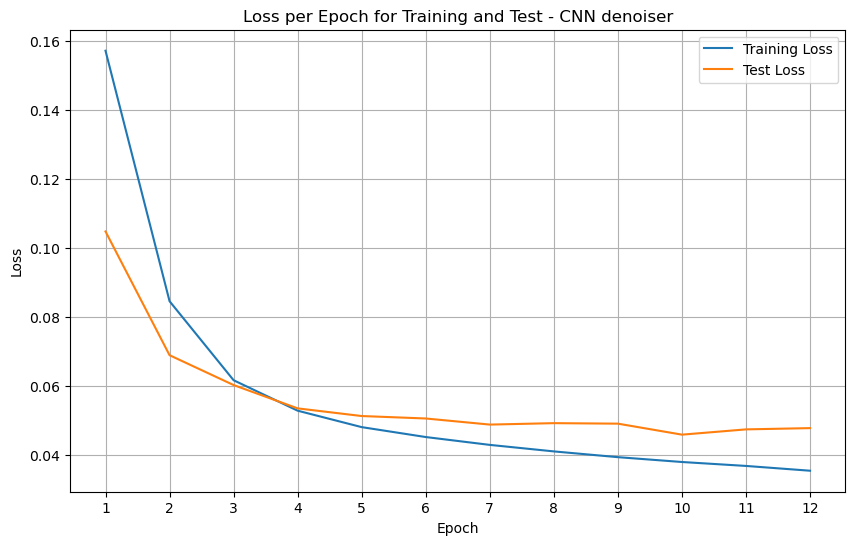

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
plt.plot(range(1, num_epochs + 1), test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch for Training and Test - CNN denoiser")
plt.xticks(range(1, num_epochs + 1))  # Dodano, aby osie X były co 1
plt.legend()
plt.grid(True)
plt.show()

Testing MLP denoiser

In [12]:
print("Eb_N0 = [0]")
test([0])
print("\nEb_N0 = [0, 1, 2, 3, 4, 5, 6, 7]")
test(Eb_N0_test)

Eb_N0 = [0]
Testing  - Loss: 0.0477, BER: 0.0163, Accuracy: 88.08%  (125056) (15632)

Eb_N0 = [0, 1, 2, 3, 4, 5, 6, 7]
Testing  - Loss: 0.0094, BER: 0.0031, Accuracy: 97.57%  (1000448) (125056)


0.00936292948843246

In [13]:
def save_test_results(Eb_N0):
    input_file = f"test_dataset/test_dataset_{Eb_N0}.csv"
    output_file = f"output/output_{Eb_N0}.csv"
    
    # Wczytaj dane z testowego pliku CSV
    data = pd.read_csv(input_file, usecols=["message", f"awgn_sign_codeword_binary_{Eb_N0}"])
    
    # Dodaj kolumnę z predykcjami do DataFrame
    data[f"mlp_denoised_{Eb_N0}"] = predictions[Eb_N0]
    
    # Zapisz DataFrame do pliku CSV
    data.to_csv(output_file, index=False)
    print(f"File created: {output_file}  ({len(data)})")

In [14]:
for elem in Eb_N0_test:
    save_test_results(elem)

File created: output/output_0.csv  (125056)
File created: output/output_1.csv  (125056)
File created: output/output_2.csv  (125056)
File created: output/output_3.csv  (125056)
File created: output/output_4.csv  (125056)
File created: output/output_5.csv  (125056)
File created: output/output_6.csv  (125056)
File created: output/output_7.csv  (125056)
